In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from pycirclize import Circos
from scipy.interpolate import splprep, splev
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
import ot
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap

import surprise as sup

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# Load the data 

In [2]:
# load ann data
resolution = 1000000
population_path = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_anndata.h5ad"

start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()

# sort the object by global bin id
sorted_indices = adata.obs['bin'].argsort()
adata = adata[sorted_indices, :] 

adata.uns['chrom_sizes']['n_bins'] = adata.uns['chrom_sizes']['size'] // adata.uns['base_resolution']
adata.uns['chrom_sizes'].head()

adata

Time taken to read the file: 8.87 seconds
Memory usage: current 1.53 GB, difference +1.53 GB


View of AnnData object with n_obs × n_vars = 2579 × 2756467
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'

In [3]:
def find_outliers(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers(adata.obs['degree'])

print(adata.obs['degree_outlier'].value_counts())

# remove outliers
remove_bins = adata.obs[adata.obs['degree_outlier']].index.to_list()
print(f"Removing top {len(remove_bins)} outlier loci: ")
print(remove_bins)

adata = adata[~adata.obs_names.isin(remove_bins), :].copy()

print('done!')

degree_outlier
False    2431
True      148
Name: count, dtype: int64
Removing top 148 outlier loci: 
['chr1:24', 'chr1:85', 'chr1:195', 'chr2:98', 'chr2:177', 'chr4:112', 'chr4:145', 'chr4:146', 'chr4:147', 'chr5:94', 'chr5:95', 'chr6:103', 'chr7:20', 'chr7:21', 'chr7:22', 'chr7:32', 'chr8:19', 'chr8:20', 'chr8:21', 'chr8:70', 'chr8:130', 'chr9:3', 'chr9:35', 'chr9:124', 'chr10:130', 'chr11:3', 'chr12:3', 'chr13:65', 'chr13:66', 'chr14:3', 'chr14:15', 'chr14:16', 'chr14:17', 'chr14:18', 'chr14:19', 'chr14:125', 'chr16:3', 'chr17:95', 'chr19:61', 'chrX:6', 'chrX:8', 'chrX:9', 'chrX:10', 'chrX:14', 'chrX:15', 'chrX:16', 'chrX:17', 'chrX:18', 'chrX:19', 'chrX:22', 'chrX:23', 'chrX:24', 'chrX:25', 'chrX:26', 'chrX:27', 'chrX:29', 'chrX:34', 'chrX:38', 'chrX:39', 'chrX:40', 'chrX:42', 'chrX:43', 'chrX:44', 'chrX:45', 'chrX:46', 'chrX:48', 'chrX:49', 'chrX:53', 'chrX:54', 'chrX:57', 'chrX:58', 'chrX:60', 'chrX:61', 'chrX:62', 'chrX:63', 'chrX:64', 'chrX:65', 'chrX:66', 'chrX:67', 'chrX:68', 

In [4]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_1000000_scores.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

columns_to_drop = [x for x in df.columns if x in adata.obs.columns]
df = df.drop(columns=columns_to_drop)
print(f"{df.shape=}")

adata.obs = pd.merge(
    adata.obs, df.set_index('bin_name'),
    how='left',
    left_index=True,
    right_index=True,
)

adata.obs.head()


df.shape=(2431, 36)
df.shape=(2431, 14)


,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,ATACSeq_1,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
bin_name,,,,,,,,,,,,,,,,,,,,,
chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,0.507852,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,0.680719,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,0.567134,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,0.621495,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,0.497991,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


# Define the core

In [5]:
order_threshold = 3
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(adata.obs[score_column], core_threshold_quantile)

print(f"Using score column: {score_column}")
print(f"Core threshold quantile: {core_threshold_quantile}")
print(f"Calculated threshold: {threshold:.3f}") 

core_nodes = adata.obs[adata.obs[score_column] > threshold].index.to_list()

print(f"Detected {(len(core_nodes))} of {len(adata.obs)} total nodes ({100*((len(core_nodes)) / len(adata.obs)):.1f}%)")

# extract the core from population
core = adata[core_nodes, :].copy()
core = core[:, core.X.sum(axis=0) > order_threshold].copy()

core

Using score column: global_hge_logexp_RNA_weighted
Core threshold quantile: 0.75
Calculated threshold: 0.352
Detected 608 of 2431 total nodes (25.0%)


AnnData object with n_obs × n_vars = 608 × 47800
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'degree_outlier', 'chrom_degree', 'ce_singular_vector_1', 'ce_eigenvector_centrality', 'ce_betweenness_centrality', 'ce_pagerank', 'hge_singular_vector_1', 'hge_logexp_unweighted', 'hge_logexp_degree_weighted', 'hge_logexp_RNA_weighted', 'hge_logexp_ATAC_weighted', 'global_singular_vector_1', 'global_hge_logexp_unweighted', 'global_hge_logexp_RNA_weighted'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes'
    uns: 'base_resolution', 'chrom_sizes'

# Load the factories

In [6]:
def make_gene_adata(df):
    # Add index identifiers
    df['read_index'] = pd.factorize(df['read_name'])[0]
    df['gene_index'] = pd.factorize(df['gene_name'])[0]
    df['val'] = 1
    
    data = df['val'].tolist()
    row = df['gene_index'].values
    col = df['read_index'].values
    
    n = df['gene_index'].nunique()
    m = df['read_index'].nunique()

    obs_names = df['gene_name'].unique()
    var_names = df['read_name'].unique()

    X = csr_matrix((data, (row, col)), shape=(n, m))
    X = csr_matrix((X > 0).astype(int))

    gdata = an.AnnData(X=X)
    gdata.obs_names = obs_names
    gdata.var_names = var_names    
    return gdata

In [7]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"

tf_list = [x.strip() for x in open(fpath)]
print(f"(raw) {len(tf_list)=}")

# load genes
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)
df['is_core'] = df['bin_name'].isin(core.obs_names)
print(f"{df.shape=}")
df.head()

(raw) len(tf_list)=1860
df.shape=(4939267, 6)


,gene_name,gene_biotype,read_name,bin_name,is_tf,is_core
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,False
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,False
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,True
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,False
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,False


In [8]:
gdata = make_gene_adata(df)

# add obs
obs = df.copy()
obs = obs.sort_values(by=['gene_name', 'is_core'], ascending=[False, False])
obs = obs.drop_duplicates(subset=['gene_name'])
obs = obs.set_index('gene_name')

obs = obs.reindex(gdata.obs_names)

gdata.obs = obs
gdata.obs['chrom'] = gdata.obs['bin_name'].str.split(":").str[0]
gdata.obs['chrom_bin'] = gdata.obs['bin_name'].str.split(":").str[1]

gdata.obsm['A'] = gdata.X @ gdata.X.T 
gdata.obsm['A'] = pd.DataFrame.sparse.from_spmatrix(
    gdata.obsm['A'],
    index=gdata.obs_names,
    columns=gdata.obs_names,
)

gdata

AnnData object with n_obs × n_vars = 47286 × 2200583
    obs: 'gene_biotype', 'read_name', 'bin_name', 'is_tf', 'is_core', 'read_index', 'gene_index', 'val', 'chrom', 'chrom_bin'
    obsm: 'A'

# Genome-wide TFs

In [9]:
query = 'Foxp1'
df[df['gene_name'] == query]

,gene_name,gene_biotype,read_name,bin_name,is_tf,is_core,read_index,gene_index,val
2348,Foxp1,protein_coding,ebf68420-346f-48d8-8245-0b138f19bdee,chr6:98,True,False,2345,1571,1
5469,Foxp1,protein_coding,547dca50-bc0f-4ac0-862e-42d6358e3fe3,chr6:99,True,False,5455,1571,1
5938,Foxp1,protein_coding,481fbfcd-cb5d-4e78-be74-f7ac59b1fc82,chr6:99,True,False,5920,1571,1
5939,Foxp1,protein_coding,1c7882c9-832b-45e2-8d85-83c3fb9baec0,chr6:99,True,False,5921,1571,1
6017,Foxp1,protein_coding,9c677fc1-855b-4f8b-a49f-54f74580908b,chr6:99,True,False,5999,1571,1
...,...,...,...,...,...,...,...,...,...
4932283,Foxp1,protein_coding,b2829612-d88e-4674-b337-2cb8ecfbc793,chr6:98,True,False,1747938,1571,1
4936559,Foxp1,protein_coding,2a3a0cc8-900b-41f2-b862-226271aceb14,chr6:99,True,False,1915959,1571,1
4936794,Foxp1,protein_coding,a5409a78-f7b6-47f2-8bf4-c02f0d0e5dd1,chr6:99,True,False,412256,1571,1
4936796,Foxp1,protein_coding,1afcf10f-ba09-4a7e-af8b-bbdee21d047c,chr6:99,True,False,2077854,1571,1


# circos

In [11]:
tf = 'Hivep3'
biotype = 'protein_coding'
core_only = True
order_threshold = 2

query = gdata.copy()

# drop predicted genes
query = query[~query.obs.index.str.startswith('Gm'), :].copy()
query = query[query.obs['gene_biotype'] == biotype, :].copy()
if core_only:
    query = query[query.obs['is_core'], :].copy()

bin_map = dict(zip(adata.obs.index, adata.obs['bin']))

# Get the row corresponding to the obs_index
row_data = query[tf, :].X.todense()

# Find columns where the row data is 1 and the column sum is greater than n
mask = (row_data == 1) & (query.X.sum(axis=0) > order_threshold)

# Slice the AnnData object using the valid columns
query = query[:, mask].copy()
query = query[query.X.sum(axis=1) > 2, :].copy() # only consider genes that are seen in these  contacts

# add the global bin ids and sort
query.obs['bin'] = query.obs['bin_name'].map(bin_map)
sorted_indices = query.obs['bin'].argsort()
query = query[sorted_indices, :].copy()

matrix.expand_and_normalize_anndata(query)

query

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.


AnnData object with n_obs × n_vars = 26 × 242
    obs: 'gene_biotype', 'read_name', 'bin_name', 'is_tf', 'is_core', 'read_index', 'gene_index', 'val', 'chrom', 'chrom_bin', 'bin'
    obsm: 'A', 'A_kr', 'A_oe'

In [12]:
edge_list = pd.melt(
    query.obsm['A'].reset_index(), id_vars='index',
)

edge_list.columns = ['gene_i', 'gene_j', 'weight']
edge_list = edge_list[edge_list['gene_i'] != edge_list['gene_j']] # drop the diagonal
edge_list = edge_list[edge_list['weight'] > 0]

print(f"{edge_list.shape=}")
edge_list = edge_list.sort_values(by='weight', ascending=False)
edge_list.head()

edge_list.shape=(106, 3)


,gene_i,gene_j,weight
375,Foxj3,Hivep3,8
300,Hivep3,Foxj3,8
326,Hivep3,Zmynd12,7
352,Hivep3,Ccdc30,7
377,Ccdc30,Hivep3,7


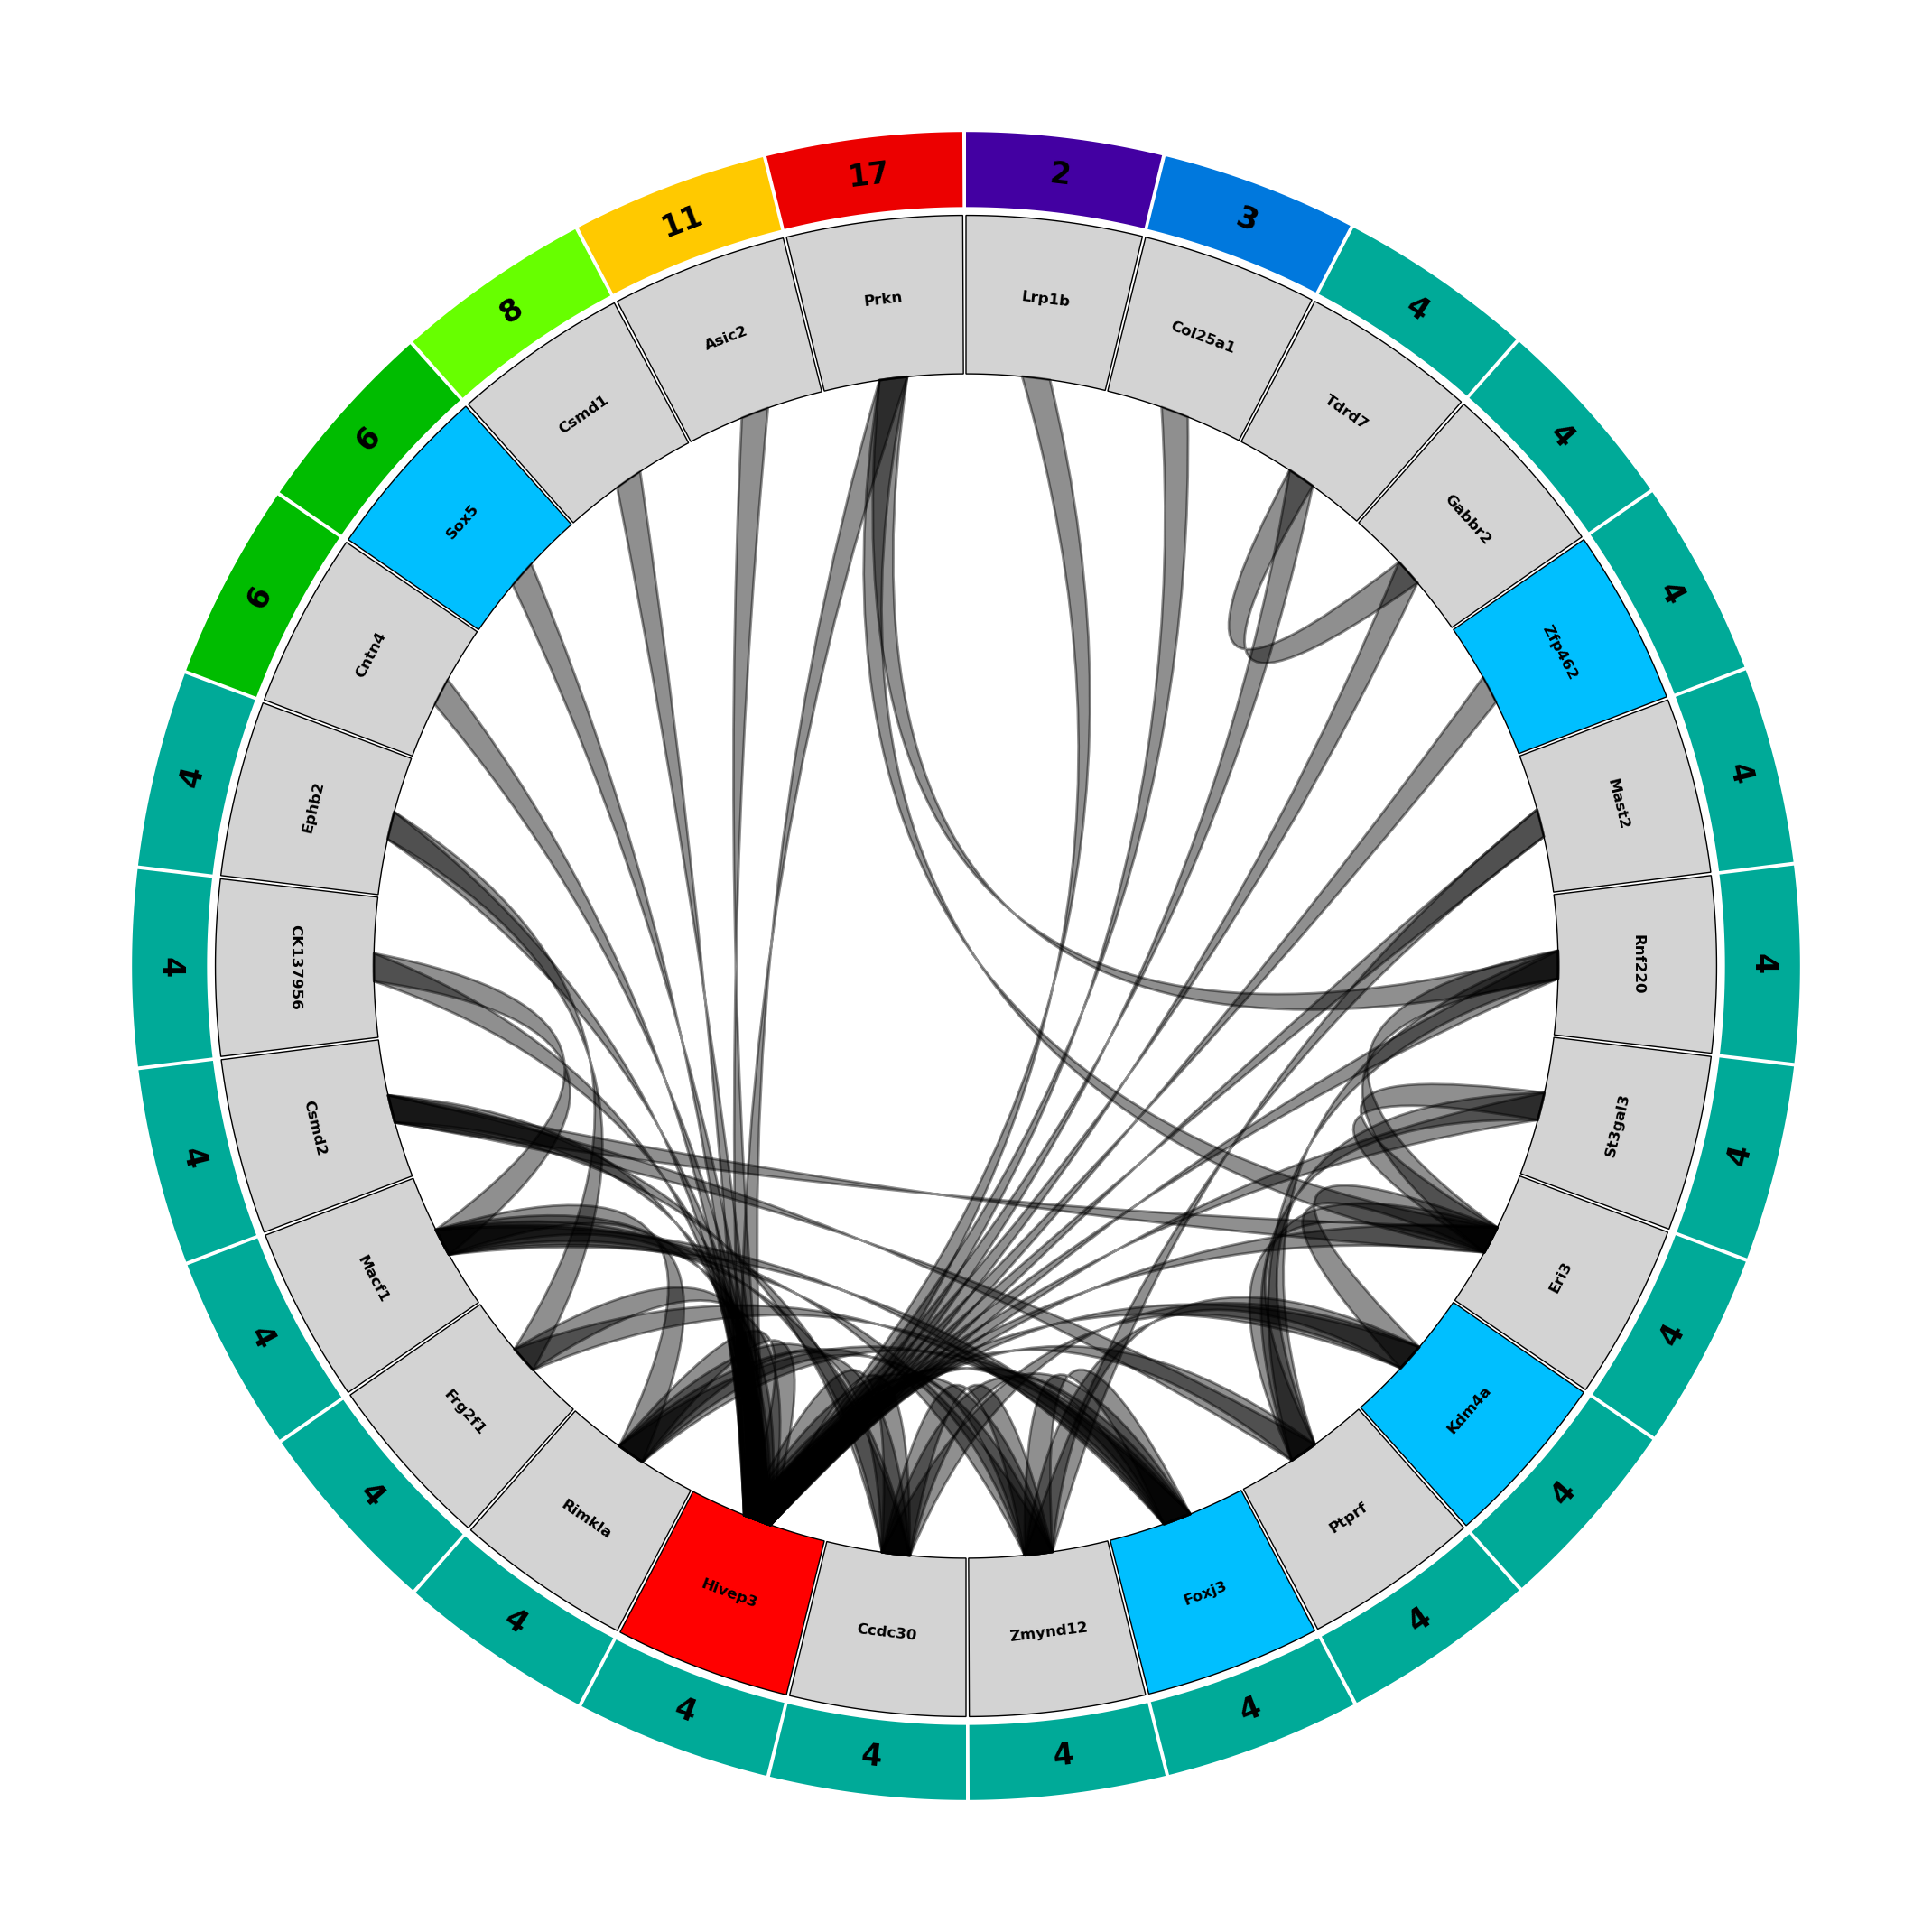

In [13]:
sectors = dict(zip(
    query.obs_names, 
    [10] * len(query.obs_names),
))

chrom_colors = colors = plt2.get_n_colors(
    query.obs['chrom'].nunique() + 2, 
    cmap_name='nipy_spectral',
)

chrom_colors = dict(zip(
    query.obs['chrom'].unique(),
    chrom_colors[1:-1]
))

circos = Circos(sectors, space=0.25)

for i, sector in enumerate(circos.sectors):    
    meta = query.obs.iloc[i]
    chrom = meta['chrom']

    # add chromosome track
    track = sector.add_track((91, 100))
    track.axis(
        fc=chrom_colors[chrom], 
        ec='none',
    )

    track.text(
        chrom.replace("chr", ""), 
        color="k", 
        fontweight='bold',
        fontsize=12,
    )

    # add gene blocks
    color = 'lightgrey'
    if meta['is_tf']:
        color = 'deepskyblue'
    if sector.name == tf:
        color = 'r'
    track = sector.add_track((71, 90))
    track.axis(
        fc=color, 
    )
    track.text(
        sector.name, 
        color="k", 
        fontweight='bold',
        fontsize=6,
    )


for idx, row in edge_list.iterrows():    
    circos.link(
        (row['gene_i'], 4, 6), 
        (row['gene_j'], 4, 6),  
        color='k', 
        lw=1, 
        height_ratio=0.2,
        alpha=0.25, 
    )          

fig = circos.plotfig(
    dpi=200,
    figsize=(10, 10)
)


In [ ]:
break

In [ ]:
query.to_df().sum(axis=1) > 0

# Archive

In [ ]:
break

In [ ]:
order = 3
H = gdata.to_df().T
H = H[H.sum(axis=1) >= order]
print(f"{H.shape=}")

def get_non_zero_cols(row):
  return ".".join(sorted(list(H.columns[row.astype(bool)])))

non_zero_cols = H.apply(get_non_zero_cols, axis=1).tolist()
top_interactions = pd.DataFrame(pd.Series(non_zero_cols).value_counts()).reset_index(names='hyperedge')
top_interactions.head(15)

In [ ]:
read_counts = pd.DataFrame(
    H.sum().reset_index(),
)

read_counts.columns =['gene_name', 'count']
read_counts['is_tf'] = read_counts['gene_name'].isin(tf_list)
read_counts = read_counts.sort_values(by='count', ascending=False)
read_counts = read_counts[read_counts['is_tf']]
read_counts.head(15)

In [ ]:
n_query = 15
database = 'ontology'
query = list(read_counts['gene_name'].head(n_query))

edf = gget.enrichr(query, database=database)
edf.head(15)

# Check out gene between chromosomes with high-inter chromosomal contacts

In [ ]:
order = 3
n_top = 3

chrom_pairs = [
    ('chr11', 'chr1'),	   # 2646 unique pairs, 5131 total contacts
    ('chr11', 'chr7'),	   # 2322 unique pairs, 4588 total contacts
    ('chr11', 'chr2'),	   # 2268 unique pairs, 4869 total contacts
    # ('chr7', 'chr1'),	   # 2107 unique pairs, 3603 total contacts
    ('chr11', 'chr8'),	   # 2106 unique pairs, 5039 total contacts
    # ('chr8', 'chr11'),	   # 2106 unique pairs, 5039 total contacts
    # ('chr1', 'chr2'),	   # 2058 unique pairs, 3678 total contacts
    # ('chr8', 'chr1'),	   # 1911 unique pairs, 3939 total contacts
    # ('chr5', 'chr1'),	   # 1911 unique pairs, 3575 total contacts
    # ('chr3', 'chr11'),	   # 1890 unique pairs, 3958 total contacts
]

result = []

for chrom_i, chrom_j in chrom_pairs:

    # find reads with mapped genes on both chromosomes
    i_data = gdata[gdata.obs['chrom'] == chrom_i, ].to_df().sum(axis=0) > 0
    i_reads = i_data[i_data].index

    j_data = gdata[gdata.obs['chrom'] == chrom_j, ].to_df().sum(axis=0) > 0
    j_reads = j_data[j_data].index

    # identify common reads
    common_reads = set(i_reads).intersection(set(j_reads))

    # extract hyperedges
    H = gdata[:, list(common_reads)].to_df().copy().T
    H = H[H.sum(axis=1) >= order]
    print(f"{chrom_i}-{chrom_j} {H.shape=}")

    if H.empty:
        continue

    H = H.apply(lambda x: list(H.columns[x.astype(bool)]), axis=1)
    H = pd.DataFrame(H, columns=['hyperedge'])
    H['chroms'] = f"{chrom_i}-{chrom_j}"
    result.append(H)

result = pd.concat(result)
print(f"{result.shape=}")

# id the reads that contain a TF
def check_list(lst):
  return any(elem in tf_list for elem in lst)
    
result['has_tf'] = result['hyperedge'].apply(check_list)
print(result['has_tf'].value_counts())

result.head()

In [ ]:
sample_size = 10

# plot the ones with a TF
pdf = result.copy()
# pdf = pdf[pdf['has_tf']]
pdf = pdf.reset_index(drop=False)
print(f"{pdf.shape=}")

pdf = pdf.sample(sample_size)
pdf = pdf.reset_index(drop=True)

for idx, row in pdf.iterrows():

    hyperedge = row['hyperedge']

    sns.pointplot(
        x=[idx] * len(hyperedge),
        y=hyperedge,
    )

    # break


pdf.head()

In [ ]:
gdata

In [ ]:
break

# Make an incidence matrix of protien coding genes

In [ ]:
n_genes = 50
min_gene_count = 75

# extract the reads with top TFs
genes = df[df['is_tf'] & df['is_core']]['gene_name'].value_counts().head(n_genes).index
genes = list(genes)
print(genes[:5])

read_names = df[df['gene_name'].isin(genes)]['read_name'].unique()

# use the full read for reads containing these TFs
reads = df[df['read_name'].isin(read_names)]
reads = reads[reads['gene_biotype'] == 'protein_coding']
reads = reads[~reads['gene_name'].str.startswith("Gm")] # drop predicted
reads = reads[~reads['gene_name'].str.endswith("Rik")] # drop predicted
print(f"(reads with top {n_genes} TFs:) {reads.shape=}")
print(f"(reads with top {n_genes} TFs:) {reads['gene_name'].nunique()=}")


# drop infrequently appearing genes
reads['gene_count'] = reads.groupby('gene_name')['read_name'].transform('nunique')
reads = reads[reads['gene_count'] > min_gene_count]

# drop reads with low-order 
reads['order'] = reads.groupby('read_name')['gene_name'].transform('nunique')
reads = reads[reads['order'] > 1]

print(f"(reads with top {n_genes} TFs and {min_gene_count}) {reads.shape=}")
print(f"(reads with top {n_genes} TFs and {min_gene_count}) {reads['gene_name'].nunique()=}")

reads = reads.sort_values(by='read_name')

reads.head()

In [ ]:
database = 'ontology'
query = list(reads['gene_name'].unique())

edf = gget.enrichr(query, database=database)
edf.head(15)

In [ ]:
gdata = make_gene_adata(reads)

# add obs
obs = reads.copy()
obs = obs.sort_values(by=['gene_name', 'is_core'], ascending=[False, False])
obs = obs.drop_duplicates(subset=['gene_name'])
obs = obs.set_index('gene_name')
obs = obs.reindex(gdata.obs_names)
gdata.obs = obs

gdata.obsm['A'] = gdata.X @ gdata.X.T 
gdata.obsm['A'] = pd.DataFrame.sparse.from_spmatrix(
    gdata.obsm['A'],
    index=gdata.obs_names,
    columns=gdata.obs_names,
)

gdata

# Network plots

In [ ]:
obsm_key = 'A'
edge_scale = 25

node_attributes = gdata.obs.copy()
node_attributes = node_attributes.to_dict(orient='index')

# define the graph
A = gdata.obsm[obsm_key].copy()
A = A.mask(np.eye(A.shape[0], dtype=bool), 0)
G = nx.from_pandas_adjacency(A)


nx.set_node_attributes(G, node_attributes)

G.pos = nx.spring_layout(
    G, 
    seed=32, k=0.5,
    iterations=100,
)
print(G)

node_colors = ['deepskyblue' if G.nodes[node]['is_tf'] else 'orange' for node in G.nodes]
node_sizes = np.log1p(ut.min_max(np.asarray([G.nodes[node]['gene_count'] for node in G.nodes])))
node_labels = [node for node in G.nodes]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10

# nx.draw_networkx_nodes(
#     G, 
#     G.pos,
#     node_size=node_sizes*1200,
#     node_color=node_colors,
#     edgecolors='black', 
#     linewidths=0.5,      
# )

for node in G.nodes:
    node_attr = G.nodes[node]
    
    node_color = 'k'
    facecolor = 'lightgrey'
    if node_attr['is_tf']:
        node_color = 'blue'

    if node_attr['is_core']:
        facecolor = 'lightcoral'

    nx.draw_networkx_labels(
        G,
        G.pos,
        labels={node: node},
        font_size=8,
        font_color=node_color,
        font_weight='bold',
        bbox=dict(facecolor=facecolor, edgecolor='k', lw=0.5)
    )

edge_widths = np.asarray([(d['weight']) for u, v, d in G.edges(data=True)])
edge_widths = np.sqrt(ut.min_max(edge_widths) * edge_scale)

nx.draw_networkx_edges(
    G, 
    G.pos,
    width=edge_widths,
    edge_color='k',
    alpha=0.5,
)

# frequent three ways

In [ ]:
order = 3
H = gdata.to_df().T
H = H[H.sum(axis=1) >= order]
print(f"{H.shape=}")

def get_non_zero_cols(row):
  return ".".join(sorted(list(H.columns[row.astype(bool)])))

non_zero_cols = H.apply(get_non_zero_cols, axis=1).tolist()
top_interactions = pd.DataFrame(pd.Series(non_zero_cols).value_counts()).reset_index(names='hyperedge')
top_interactions

In [ ]:
def plot_polygon_with_padding(x, y, padding, smoothness=0.5, fill=False, ax=None, 
                              edge_kwargs=None, fill_kwargs=None):
  """
  Plots a polygon enclosing the given points with padding and rounded corners.

  Args:
    x: A list of x-coordinates for the points.
    y: A list of y-coordinates for the points.
    padding: The padding distance around the points.
    smoothness: A value controlling the smoothness of the rounded corners.
               Lower values produce sharper corners, higher values produce smoother corners.
    fill: A boolean indicating whether to fill the polygon.
    ax: An optional matplotlib axes object to plot on. If None, the current axes will be used.
    edge_kwargs: Keyword arguments passed to the `plt.plot` function for the polygon edge.
    fill_kwargs: Keyword arguments passed to the `plt.fill` function for the polygon fill.
  """

  if ax is None:
    ax = plt.gca()

  if edge_kwargs is None:
    edge_kwargs = {}

  if fill_kwargs is None:
    fill_kwargs = {}

  # Calculate the centroid of the points
  centroid_x = np.mean(x)
  centroid_y = np.mean(y)

  # Calculate the distance of each point from the centroid
  distances = [np.sqrt((x[i] - centroid_x)**2 + (y[i] - centroid_y)**2) for i in range(len(x))]

  # Calculate the angles from the centroid to each point
  angles = [np.arctan2(y[i] - centroid_y, x[i] - centroid_x) for i in range(len(x))]

  # Calculate the new points with padding
  new_x = [centroid_x + (distances[i] + padding) * np.cos(angles[i]) for i in range(len(x))]
  new_y = [centroid_y + (distances[i] + padding) * np.sin(angles[i]) for i in range(len(x))]

  # Add the first point to the end to close the polygon
  new_x.append(new_x[0])
  new_y.append(new_y[0])

  # Smooth the polygon using spline interpolation
  tck, u = splprep([new_x, new_y], s=smoothness, per=True)
  new_points = splev(np.linspace(0, 1, 100), tck)

  # Plot the smoothed polygon
  ax.plot(new_points[0], new_points[1], **edge_kwargs)

  # Fill the polygon if specified
  if fill:
    ax.fill(new_points[0], new_points[1], **fill_kwargs)

  # Plot the original points
  ax.plot(x, y, 'o', c='k', markersize=15)


In [ ]:
top_n_interactions = 5

node_colors = ['lightcoral' if G.nodes[node]['is_core'] else 'lightgrey' for node in G.nodes]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10



ax = plt.gca()

for idx, row in top_interactions.head(top_n_interactions).iterrows():
    hyperedge = row['hyperedge']

    nodes = hyperedge.split(".")
    points = np.asarray([G.pos[node] for node in nodes])

    plot_polygon_with_padding(
        points[:, 0],
        points[:, 1],
        padding=0.75,
        ax=ax,
        smoothness=1,
        fill=True,
        edge_kwargs={'color': 'red', 'linewidth': 1},
        fill_kwargs={'color': 'blue', 'alpha': 0.25}
    )

    break
    
    # for node in nodes:
    #     # nx.draw_networkx_nodes(
    #     #     G, 
    #     #     G.pos,
    #     #     nodelist=[node],
    #     #     node_size=50,
    #     #     # node_color=node_colors,
    #     #     edgecolors='black', 
    #     #     linewidths=1,      
    #     # )

        
    #     pos = G.pos[node]  # Get the original position of the node
    #     pos = (pos[0], pos[1] + 0.05)  # A
    #     nx.draw_networkx_labels(
    #         G, {node: pos},  # Use the adjusted position for this node
    #         labels={node: node},
    #         font_size=8,
    #         font_color='k',
    # )

    # break
         

    

In [ ]:
?nx.draw_networkx_nodes

In [ ]:
break

In [ ]:
node_colors = ['lightcoral' if G.nodes[node]['is_core'] else 'lightgrey' for node in G.nodes]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10

nx.draw_networkx_nodes(
    G, 
    G.pos,
    node_size=100,
    node_color=node_colors,
    edgecolors='black', 
    linewidths=1,      
)

In [ ]:
?nx.spring_layout

In [ ]:
?nx.draw_networkx_labels

In [ ]:
break

In [ ]:
def plot_polygon_with_padding(x, y, padding, smoothness=0.5, fill=False, ax=None, 
                              edge_kwargs=None, fill_kwargs=None):
  """
  Plots a polygon enclosing the given points with padding and rounded corners.

  Args:
    x: A list of x-coordinates for the points.
    y: A list of y-coordinates for the points.
    padding: The padding distance around the points.
    smoothness: A value controlling the smoothness of the rounded corners.
               Lower values produce sharper corners, higher values produce smoother corners.
    fill: A boolean indicating whether to fill the polygon.
    ax: An optional matplotlib axes object to plot on. If None, the current axes will be used.
    edge_kwargs: Keyword arguments passed to the `plt.plot` function for the polygon edge.
    fill_kwargs: Keyword arguments passed to the `plt.fill` function for the polygon fill.
  """

  if ax is None:
    ax = plt.gca()

  if edge_kwargs is None:
    edge_kwargs = {}

  if fill_kwargs is None:
    fill_kwargs = {}

  # Calculate the centroid of the points
  centroid_x = np.mean(x)
  centroid_y = np.mean(y)

  # Calculate the distance of each point from the centroid
  distances = [np.sqrt((x[i] - centroid_x)**2 + (y[i] - centroid_y)**2) for i in range(len(x))]

  # Calculate the angles from the centroid to each point
  angles = [np.arctan2(y[i] - centroid_y, x[i] - centroid_x) for i in range(len(x))]

  # Calculate the new points with padding
  new_x = [centroid_x + (distances[i] + padding) * np.cos(angles[i]) for i in range(len(x))]
  new_y = [centroid_y + (distances[i] + padding) * np.sin(angles[i]) for i in range(len(x))]

  # Add the first point to the end to close the polygon
  new_x.append(new_x[0])
  new_y.append(new_y[0])

  # Smooth the polygon using spline interpolation
  tck, u = splprep([new_x, new_y], s=smoothness, per=True)
  new_points = splev(np.linspace(0, 1, 100), tck)

  # Plot the smoothed polygon
  ax.plot(new_points[0], new_points[1], **edge_kwargs)

  # Fill the polygon if specified
  if fill:
    ax.fill(new_points[0], new_points[1], **fill_kwargs)


# Example usage:
x = [1, 2, 3, 2]
y = [4, 1, 5, 3]
padding = 1.0  # Adjust padding as needed

fig, ax = plt.subplots()  # Create a figure and axes

plot_polygon_with_padding(x, y, padding, smoothness=0.3, fill=True, ax=ax,
                          edge_kwargs={'color': 'red', 'linewidth': 1},
                          fill_kwargs={'color': 'blue', 'alpha': 0.25})

plt.show()

In [ ]:
break

In [ ]:

def create_X(df):
    # Add index identifiers
    df['read_index'] = pd.factorize(df['read_name'])[0]
    df['bin_index'] = pd.factorize(df['bin'])[0]
    
    data = df['val'].tolist()
    row = df['bin_index'].values
    col = df['read_index'].values

  n = df['bin_index'].nunique()
  m = df['read_index'].nunique()

  obs_names = df['bin_index'].unique()
  var_names = df['read_index'].unique()

  X = csr_matrix((data, (row, col)), shape=(n, m))
  X = csr_matrix((X > 0).astype(int))
  return X, obs_names, var_names

In [ ]:
H = pd.pivot_table(
    reads,
    index='gene_name',
    columns='read_name',
    values='val',
    # fill_value=0.0,
)

H.shape